In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔹 Running Vanilla Transformer on: {device}")

🔹 Running Vanilla Transformer on: cuda


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x: [Batch, Seq_len, Features]
        return x + self.pe[:, :x.size(1), :]

class VanillaTransformer(nn.Module):
    """
    Standard Transformer Encoder architecture for Time Series.
    """
    def __init__(self, num_features, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(num_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*2, # Matching original file config
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        # x shape: [Batch, Seq, Features]
        x = self.input_proj(x)
        x = self.pos_encoder(x)

        # Causal mask: Hide future tokens
        # Mask shape: [Seq, Seq]
        mask = nn.Transformer.generate_square_subsequent_mask(x.size(1)).to(x.device)

        # Transformer Encoder
        # is_causal=True is an optimization hint for newer PyTorch versions
        out = self.transformer_encoder(x, mask=mask, is_causal=True)

        # Take the last token for prediction
        return self.output_layer(out[:, -1, :])

In [ ]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / (loss.replace(0, np.nan))
    return 100 - (100 / (1 + rs))

def create_dataset_vanilla(ticker, seq_len=30):
    print(f"\n📥 Downloading data for {ticker}...")
    try:
        # Download 2020-2024 data to match previous tasks
        df = yf.download(ticker, start='2020-01-01', end='2024-12-31', progress=False)
        if df.empty: raise ValueError("Empty data found!")
    except Exception as e:
        print(f"Error loading {ticker}: {e}"); return None, None, None, None

    # --- Feature Engineering ---
    df['Returns'] = df['Close'].pct_change()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Returns'].rolling(window=20).std()
    df['RSI'] = calculate_rsi(df['Close']) # Added RSI

    # Select features
    features = ['Close', 'Volume', 'Returns', 'MA20', 'Volatility', 'RSI']
    df = df[features].dropna()

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # Sliding Window
    X, y = [], []
    for i in range(len(scaled_data) - seq_len):
        X.append(scaled_data[i : i + seq_len])
        y.append(scaled_data[i + seq_len, 0]) # Target: Close (column 0)

    X, y = np.array(X), np.array(y)
    split = int(0.8 * len(X))

    train_ds = TensorDataset(torch.FloatTensor(X[:split]), torch.FloatTensor(y[:split]))
    test_ds = TensorDataset(torch.FloatTensor(X[split:]), torch.FloatTensor(y[split:]))

    return DataLoader(train_ds, batch_size=32, shuffle=True), DataLoader(test_ds, batch_size=32, shuffle=False), scaler, features

In [ ]:
def plot_metrics_panel(y_true, y_pred, ticker, metrics):
    errors = y_true - y_pred
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    plt.suptitle(f"Vanilla Transformer Analysis: {ticker}", fontsize=16, fontweight='bold')

    # 1. Actual vs Predicted Prices
    axes[0,0].plot(y_true[-100:], label='Actual', color='#1f77b4')
    axes[0,0].plot(y_pred[-100:], label='Predicted', color='#ff7f0e', linestyle='--')
    axes[0,0].set_title("Actual vs Predicted (Last 100 days)")
    axes[0,0].legend()
    axes[0,0].text(0.05, 0.95, f"MAE: {metrics['MAE']:.3f}\nRMSE: {metrics['RMSE']:.3f}\nR2: {metrics['R2']:.3f}",
                   transform=axes[0,0].transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    # 2. Error Time Series
    axes[0,1].plot(errors, color='#2ca02c'); axes[0,1].axhline(0, color='black')
    axes[0,1].set_title("Error Time Series")

    # 3. Error Distribution
    sns.histplot(errors, kde=True, ax=axes[1,0], color='#9467bd')
    axes[1,0].set_title("Error Distribution")

    # 4. Residuals vs Actual
    axes[1,1].scatter(y_true, errors, alpha=0.3, color='#d62728'); axes[1,1].axhline(0, color='black', linestyle='--')
    axes[1,1].set_title("Residuals vs Actual Prices")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

def run_feature_sensitivity(model, test_loader, features, scaler, base_mae, ticker):
    """Feature Sensitivity Analysis (Replaces Causal Map for Vanilla models)"""
    effects = {}

    # Gather Test Data
    X_all, y_all = [], []
    for bx, by in test_loader: X_all.append(bx); y_all.append(by)
    X_test = torch.cat(X_all).to(device)
    y_test = torch.cat(y_all).numpy()

    for i, f_name in enumerate(features):
        # Nullify information from feature i
        X_mod = X_test.clone()
        X_mod[:, :, i] = 0.0

        with torch.no_grad():
            pred_mod = model(X_mod).cpu().numpy().flatten()

        # Inverse Transform
        dummy = np.zeros((len(pred_mod), len(features)))
        dummy[:, 0] = pred_mod; p_real = scaler.inverse_transform(dummy)[:, 0]
        dummy[:, 0] = y_test; y_real = scaler.inverse_transform(dummy)[:, 0]

        effects[f_name] = mean_absolute_error(y_real, p_real) - base_mae

    plt.figure(figsize=(10, 5))
    s = pd.Series(effects).sort_values()
    sns.barplot(x=s.values, y=s.index, palette="magma")
    plt.title(f"Feature Importance (Sensitivity) - {ticker}")
    plt.xlabel("Increase in MAE when feature is removed (Higher = More Important)")
    plt.show()


📥 Downloading data for GOOGL...
   🚀 Training Vanilla Transformer for GOOGL...
      Epoch 5: Loss = 0.01137
      Epoch 10: Loss = 0.00911
      Epoch 15: Loss = 0.00793
      Epoch 20: Loss = 0.00815
      Epoch 25: Loss = 0.00642


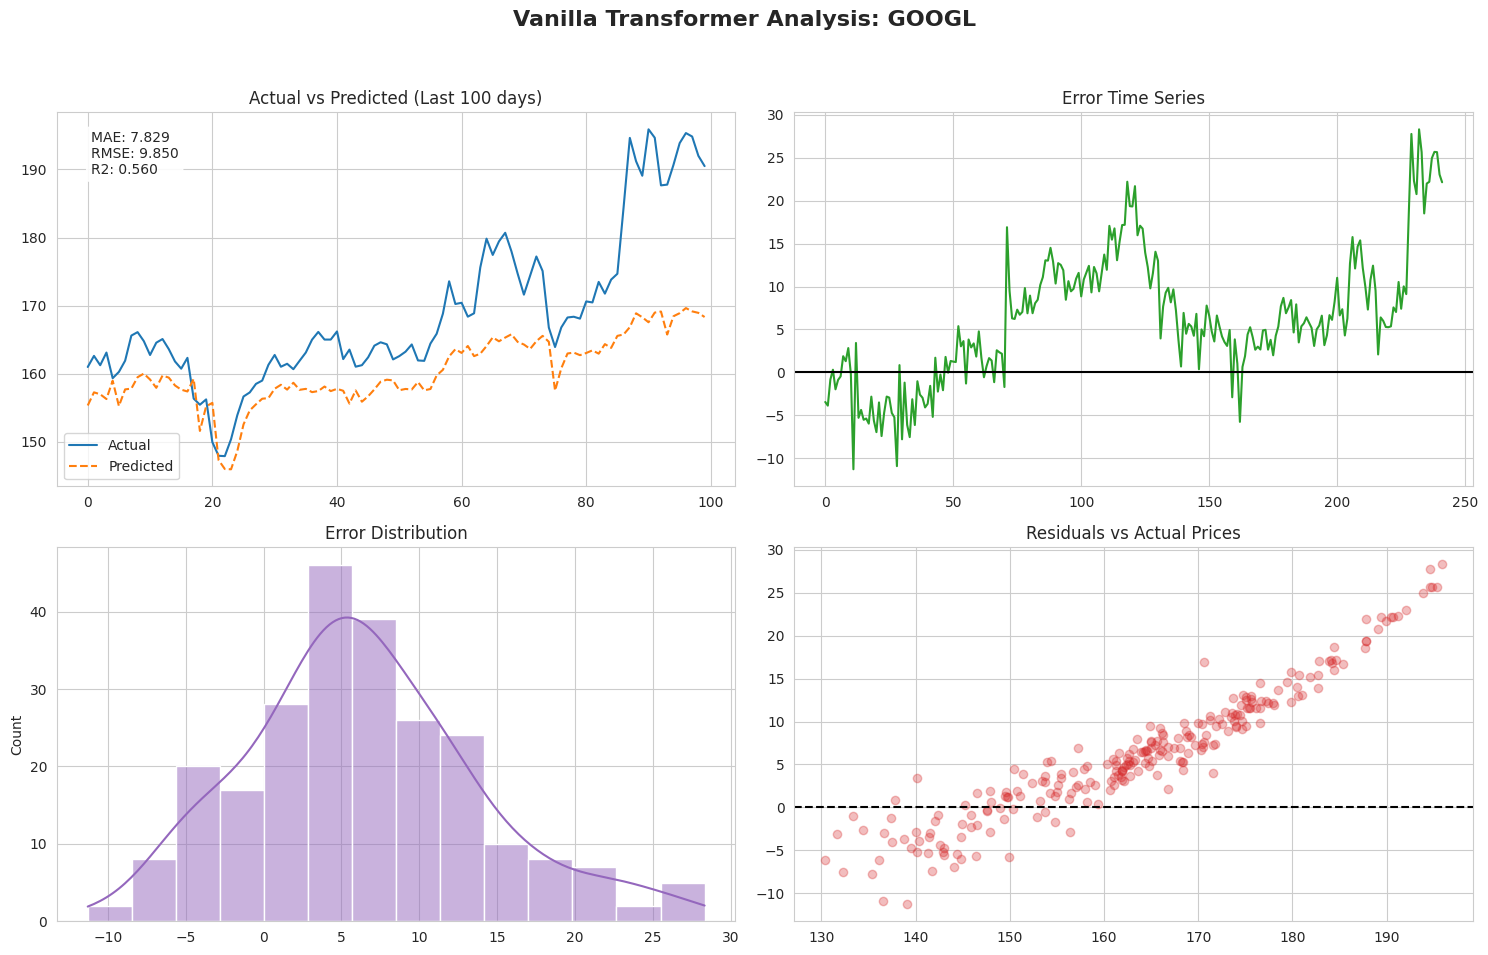

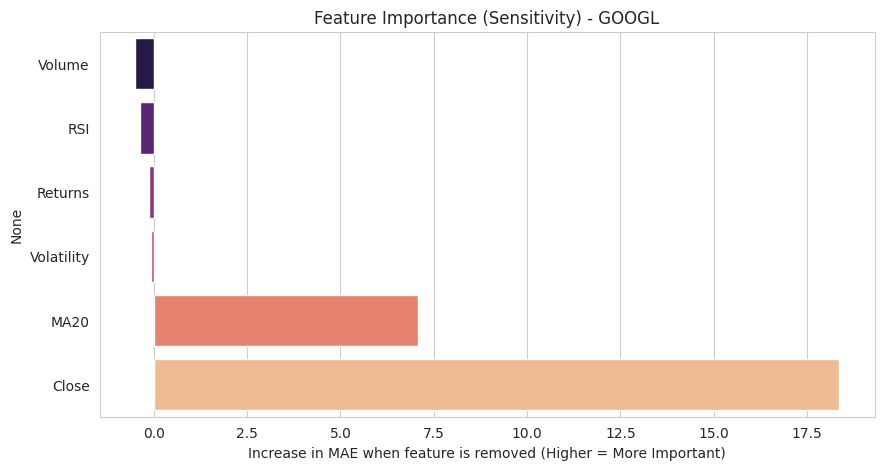


📥 Downloading data for AAPL...
   🚀 Training Vanilla Transformer for AAPL...
      Epoch 5: Loss = 0.01551
      Epoch 10: Loss = 0.01085
      Epoch 15: Loss = 0.00745
      Epoch 20: Loss = 0.00796
      Epoch 25: Loss = 0.00683


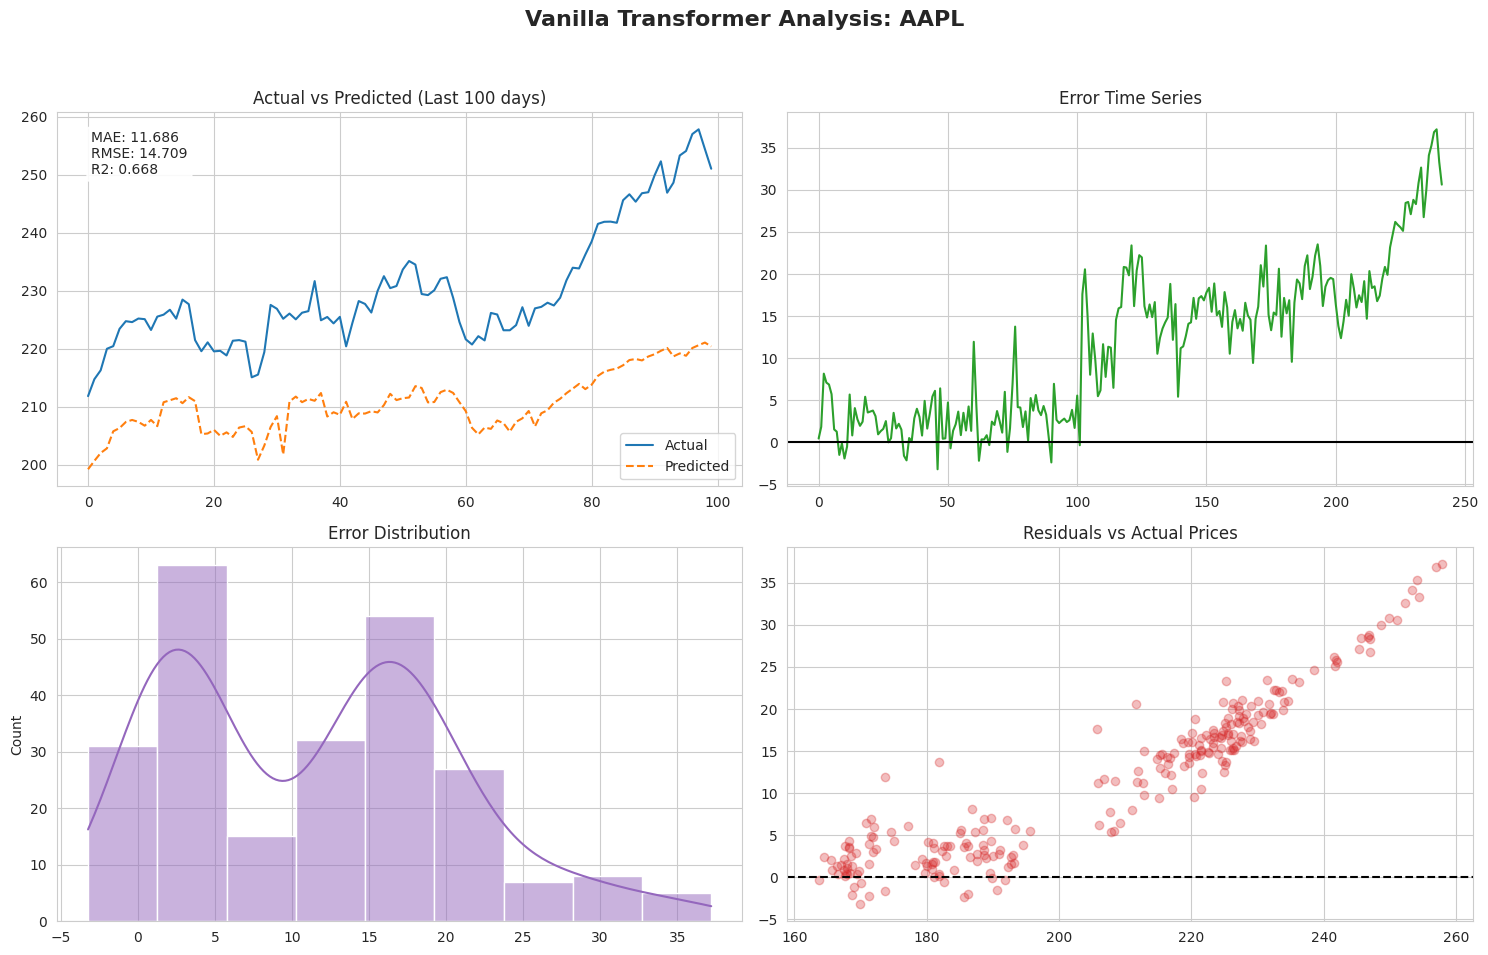

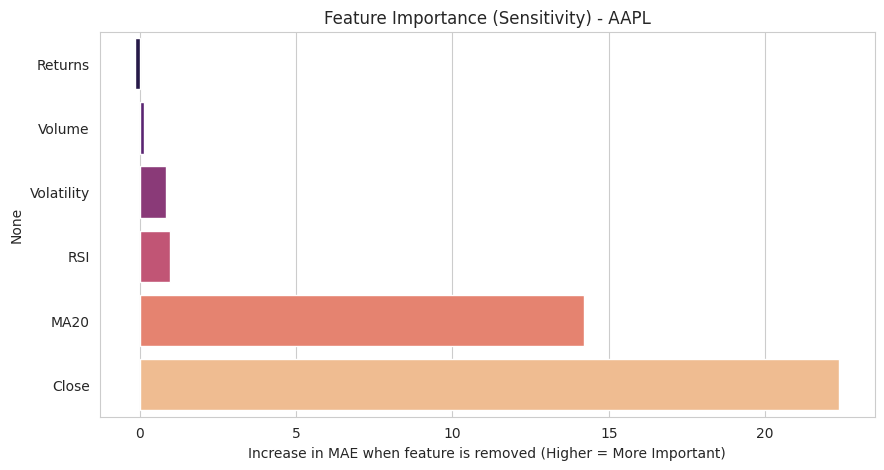


📥 Downloading data for TSLA...
   🚀 Training Vanilla Transformer for TSLA...
      Epoch 5: Loss = 0.02092
      Epoch 10: Loss = 0.01694
      Epoch 15: Loss = 0.01655
      Epoch 20: Loss = 0.01435
      Epoch 25: Loss = 0.01289


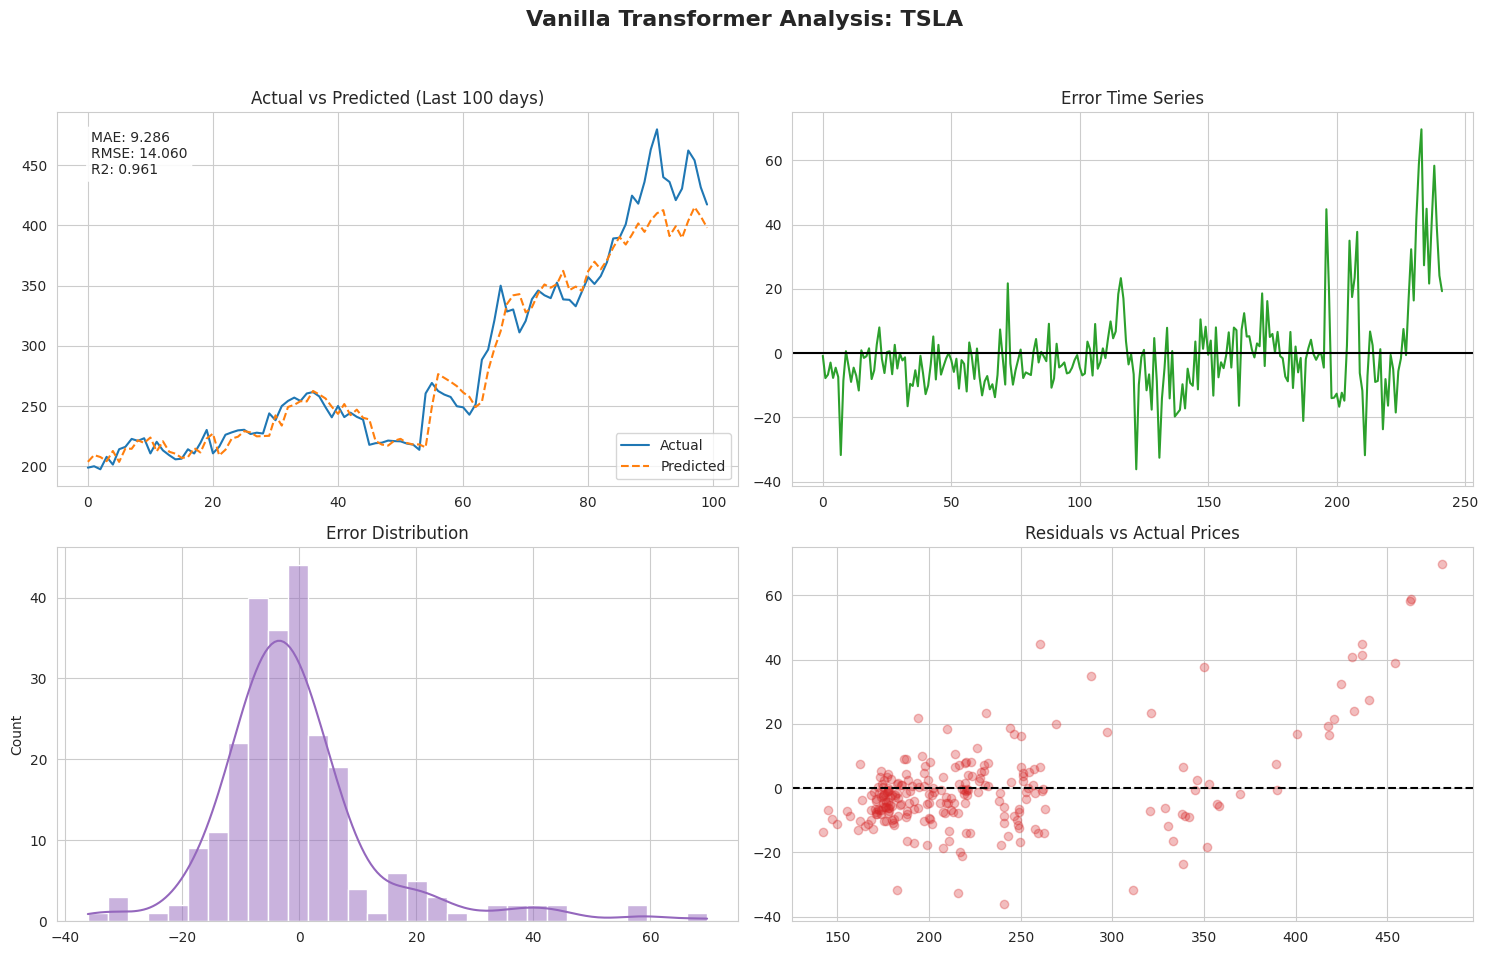

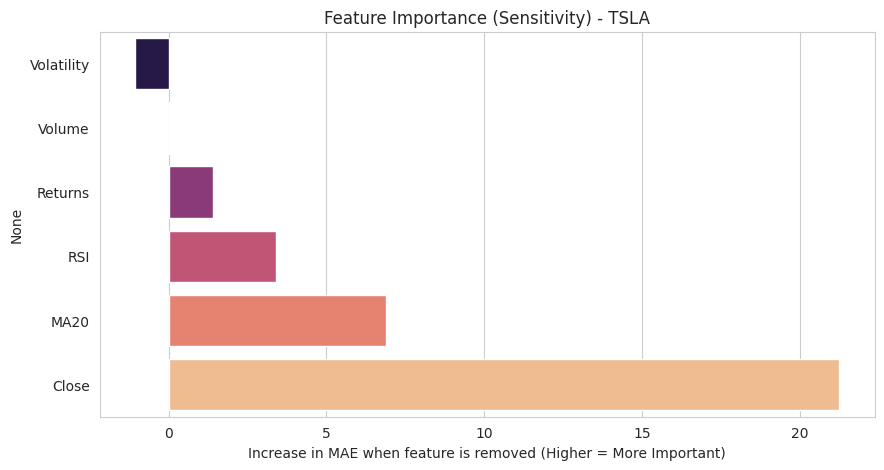


📊 --- COMPARISON RESULTS (VANILLA TRANSFORMER) ---
  Ticker        MAE       RMSE        R2
0  GOOGL   7.829241   9.850048  0.560078
1   AAPL  11.685514  14.709090  0.668025
2   TSLA   9.285535  14.059607  0.961234


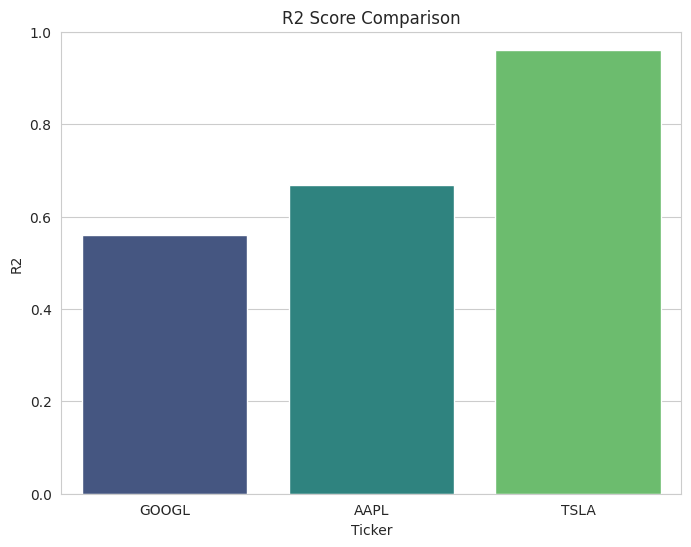

In [ ]:
# ==============================================================================
# PART 5: EXPERIMENTAL RUN
# ==============================================================================

tickers = ['GOOGL', 'AAPL', 'TSLA']
comparison_results = []

for ticker in tickers:
    train_loader, test_loader, scaler, features = create_dataset_vanilla(ticker)
    if train_loader is None: continue

    # Initialize Model
    model = VanillaTransformer(num_features=len(features), d_model=64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    print(f"   🚀 Training Vanilla Transformer for {ticker}...")
    model.train()
    for epoch in range(25): # 25 Epochs
        epoch_loss = 0
        for bx, by in train_loader:
            bx, by = bx.to(device), by.to(device)
            optimizer.zero_grad()
            output = model(bx)
            loss = criterion(output.squeeze(), by)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch+1) % 5 == 0:
            print(f"      Epoch {epoch+1}: Loss = {epoch_loss/len(train_loader):.5f}")

    # Evaluation
    model.eval()
    preds_list, true_list = [], []
    with torch.no_grad():
        for bx, by in test_loader:
            bx = bx.to(device)
            p = model(bx)
            preds_list.append(p.cpu().numpy())
            true_list.append(by.numpy())

    preds = np.concatenate(preds_list).flatten(); targets = np.concatenate(true_list).flatten()

    # Inverse Transform
    dummy_p = np.zeros((len(preds), len(features))); dummy_p[:, 0] = preds
    y_pred_real = scaler.inverse_transform(dummy_p)[:, 0]

    dummy_t = np.zeros((len(targets), len(features))); dummy_t[:, 0] = targets
    y_true_real = scaler.inverse_transform(dummy_t)[:, 0]

    # Metrics
    mae = mean_absolute_error(y_true_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    r2 = r2_score(y_true_real, y_pred_real)

    res = {"Ticker": ticker, "MAE": mae, "RMSE": rmse, "R2": r2}
    comparison_results.append(res)

    # Visualization
    plot_metrics_panel(y_true_real, y_pred_real, ticker, res)
    run_feature_sensitivity(model, test_loader, features, scaler, mae, ticker)

# Comparison
print("\n📊 --- COMPARISON RESULTS (VANILLA TRANSFORMER) ---")
df_comp = pd.DataFrame(comparison_results)
print(df_comp)

plt.figure(figsize=(8, 6))
sns.barplot(data=df_comp, x='Ticker', y='R2', palette='viridis')
plt.title("R2 Score Comparison"); plt.ylim(0, 1)
plt.show()